# Ohio 2022 PBER

From Geoff: “What I would like by June 20th is a csv that assigns each 2020 Census block to a 2022 precinct from the Ohio SoS's general election results file.”

To Geoff: “…We've decided to start processing the shapefiles now so that there'll be minimal lag time between collection and release of the file. Although I don't anticipate this, in a worst case scenario, we'd be happy to share with you whatever intermediate file we have by June 20th.”

## Fine to use 2020 data vs Need digitization tracking

- * indicates adopted pre-2020 and therefore no updates needed
- P indicates the collection team only found PDF maps, no geospatial data

* ashtabula - used for 10 years except for single parcel change 1/24/23 in Orwell TWP/Orwell Vill
* P adams - not changed for 2022, not sure when first adopted
(P allen - map dated 9-28-21)
* athens - adopted in 2011
* P auglaize - date stamped 9/26/06
* belmont - adopted 2012/updated 2019
brown - adopted 5-21
butler - adopted 2-22
* P carrol - adopted 2019 or earlier
* P champaign - adopted 5-18
* P clinton - no change for 2022, not sure when first adopted
clark - adopted early 2022
clermont - adopted early 2022
columbiana - adopted 11-21
* P coshockton - no change for 2022, not sure when first adopted
* P crawford - no change for 2022, not sure when first adopted
cuyahoga - not sure when adopted
* P darke - no change for 2022, not sure when first adopted
* P defiance - first adopted 2018
delaware - adopted 2-2022
erie - adopted 1-2021
* fairfield - first adopted 2019
* fayette - adopted 2019 or earlier
* franklin - first adopted 8-2019
* fulton - first adopted 1-2019
* P gallia - no change for 2022, not sure when first adopted
geauga - first adopted 9-2021
* P greene - first adopted 2015, used 2020
* P guernsey - adopted 2005
hamilton - adopted early 2022
* hancock - adopted 2-2020, same map as 2020
hardin - no change for 2022, not sure when first adopted
* P harrison - wip, first adopted 2010
* henry - first adopted 1-2019
* highland - first adotped 2018 - cant be used but do match 2020 seems
hocking - first adopted 2021/2022
* holmes - first adopted 1/1/14
(P huron - first adoped 3/17 or 2021, based on map date stamp vs BOE director)
* P jackson - "many years ago"
* jefferson - adopted 2012
* knox - adopted 11/2019
* lawrence - precinct havent changed in 20 years, they claim
lake - first adopted 2021
* licking - first adopted 2015
* logan - "Used the 2018 map for all three 2022 elections"
* lorain - adopted after 2022 general election (so ...2022 general and prim used 2020 precs?)
* lucas - adopted 2019
(P madison - adopted 2022 (before or after elections?))
* mahoning - adopted 2012
* marion - adopted august 2015 used for primary elections, august 2022 map used for gen elec
medina - no info in metadata on previous use
* meigs - no change for 2022 - think this means same as 2020
mercer - new for 2022
miami - new for 2022
* monroe - adopted pre-2018
* P morgan - adopted pre-2019
* morrow - adopted 2017 or earlier
montgomery - adopted march 2022, used in primaries too
muskingum - adopted 2022
* noble - no 2022 changes, think this means same as 2020
* ottawa - adopted December 2022, so I think 2020 map likely used for actual elections?
* paulding - adopted pre 2020
* perry - adopted 2013
pickaway - adopted early 2022
* P pike - adopted 2002
portage - adopted 2022 for general, 2017 for primary
* P preble - no 2022 changes, so I think 2020 map works
* putnam - no 2022 changes, stamped 2019 - given other spots that say "before 2020" not sure
* richland - adopted 2018 or earlier
* ross - adopted 2013
* P sandusky - adopted 2009
* P scioto - adopted before 2020
* shelby - adopted before 2020
stark - adopted 2022
* summit - adopted 2013, a change in 2017 (and dec 2022?)
tuscarawas - adopted between 2020 and 2022
* union - adopted 2019
* P vanwert - adopted pre-2020
* P vinton - adopted pre-2020
* warren - adopted pre-2020
* washington - adopted 2016 or earlier
* wayne - adopted 2015, some updates since (not nec any one shp ever used??)
* williams - adopted pre-2019
wood - adopted early 2022
* P wyandot - adopted 2019 - one 2022 update due to cong split (?)

## Imports libraries and 2022 Election Results

In [1]:
import os
import geopandas as gp
import pandas as pd
from op_verification import reference_data


#set of counties with new precinct boundaries since 2020 and therefore new precinct name matching required
prec_counties_new22_set = {"brown","butler","clark","clermont","columbiana","cuyahoga","delaware", "erie","geauga","hamilton","hardin", 
                     "hocking","lake","medina","mercer","miami","montgomery","muskingum","pickaway","portage","stark","tuscarawas","wood"}

#Removed from above set after checking pdf map with 2020 map by SN on 6/7: ,"madison", "huron"
#Removed because no 2022 available and statement that no changes since 2020: "allen"
len(prec_counties_new22_set)


#2022 precinct eletion results, no geospatial data
er22 = pd.read_csv('./oh_2022_gen_prec/oh_2022_gen_prec.csv')

## Compare 2020 boundary precincts to 2022 election result precincts

In [2]:
#2020 precinct boundaries and election results file filtered for only boundaries
bound20rdh = gp.read_file("./oh_gen_20_prec/oh_gen_20_st_prec.shp")[['UNIQUE_ID', "STATEFP20","COUNTYFP20", "PRECINCT20","NAME20","geometry"]]

#Format county/county name columns to maptch ER22 for comparison
bound20rdh['COUNTY'] = ("39"+bound20rdh['COUNTYFP20']).map(reference_data.geoid_to_county_name)
bound20rdh['COUNTYNM'] = bound20rdh['COUNTY'].str.lower().str.slice(stop=-7)

#Confirm county names match up
assert set(bound20rdh['COUNTYNM'])-set(er22["County"].str.lower()) == set()
assert set(er22["County"].str.lower())-set(bound20rdh['COUNTYNM']) == set()

#Note "ZZZ"/"VOTING DISTRICTS NOT DEFINED" refers to water areas with no precinct but should be included in the map

In [3]:
#Considering 2020/2022 comparison some more
print("unique_id nunique: ",er22["UNIQUE_ID"].nunique() ,"shape: ", er22["UNIQUE_ID"].shape, "prec name nunique: ", er22["PRECNAME"].nunique())
print(bound20rdh.shape, bound20rdh["NAME20"].nunique(), bound20rdh["PRECINCT20"].nunique())
print((er22["PRECCODE"]+er22["County"]).nunique())
print((bound20rdh["PRECINCT20"]+bound20rdh["COUNTYNM"]).nunique())
'''
Bounds have more unique, but also includes the ZZZ dist, so should be ok/expected
#I can join the er and bounds on preccode/county, then still use PRECNAME/UNIQUE_ID from og er
Include zzz vtd shapes with note in readme that they were not assigned votes
OR export those shapes separately, see if they even have area/meaning'''

unique_id nunique:  8933 shape:  (8933,) prec name nunique:  8760
(8941, 8) 8673 1550
8933
8941


'\nBounds have more unique, but also includes the ZZZ dist, so should be ok/expected\n#I can join the er and bounds on preccode/county, then still use PRECNAME/UNIQUE_ID from og er\nInclude zzz vtd shapes with note in readme that they were not assigned votes\nOR export those shapes separately, see if they even have area/meaning'

In [4]:
#set of counties with reused precinct boundaries from pre-2020, therefore can use 2020 geospatial data
counties_reused22_set = set(er22["County"].str.lower())-prec_counties_new22_set

#2022 ER df subset counties where geospatial data can be reused
er22_reused_counties_df = er22[er22["County"].str.lower().isin(counties_reused22_set)]

#2020 Bound gdf subset counties where geospatial data can be reused
bound20_reused_counties_gdf = bound20rdh[(bound20rdh["COUNTYNM"].isin(counties_reused22_set))|(bound20rdh["PRECINCT20"]=="ZZZ")]


#Check if Precincts line up/what mismatches
#print("\n","prec diff: bound comp er len: ", len(set(bound20_reused_counties_gdf["PRECINCT20"])-set(er22_reused_counties_df["PRECCODE"])))
#print("prec diff: bound comp er names: ", set(bound20_reused_counties_gdf["PRECINCT20"])-set(er22_reused_counties_df["PRECCODE"]))
#print("prec diff: er comp bound len: ", len(set(er22_reused_counties_df["PRECCODE"])-set(bound20_reused_counties_gdf["PRECINCT20"])))
print("\n prec w/county diff: bound comp er len: ", len(set(bound20_reused_counties_gdf["PRECINCT20"]+bound20_reused_counties_gdf["COUNTYNM"].str.lower())-set(er22_reused_counties_df["PRECCODE"]+er22_reused_counties_df["County"].str.lower())))
print("prec w/county diff: er comp bound len: ", len(set(er22_reused_counties_df["PRECCODE"]+er22_reused_counties_df["County"].str.lower())-set(bound20_reused_counties_gdf["PRECINCT20"]+bound20_reused_counties_gdf["COUNTYNM"])))
print("prec county diff: er comp bound names: ", set(er22_reused_counties_df["PRECCODE"]+er22_reused_counties_df["County"].str.lower())-set(bound20_reused_counties_gdf["PRECINCT20"]+bound20_reused_counties_gdf["COUNTYNM"]))
print("prec county diff: bound comp er names: ", set(bound20_reused_counties_gdf["PRECINCT20"]+bound20_reused_counties_gdf["COUNTYNM"].str.lower())-set(er22_reused_counties_df["PRECCODE"]+er22_reused_counties_df["County"].str.lower()))

'''Impacts ["marion","lorain","lucas"] counties

**Maybe for Marion, Lorain, Lucas I will end up using new boundaries afterall?**

Ashtabula, Ottawa only unmatched at ZZZ place, so that is appropriate to keep.

Montgomery, Stark not showing up as an issue post-merge?
'''


 prec w/county diff: bound comp er len:  30
prec w/county diff: er comp bound len:  13
prec county diff: er comp bound names:  {'ALTlorain', 'ALOlorain', 'AABmarion', 'ALRlorain', 'ALSlorain', 'ALXlorain', 'ALUlorain', 'ABCmarion', 'AWBlucas', 'ALQlorain', 'ALNlorain', 'ALPlorain', 'ALVlorain'}
prec county diff: bound comp er names:  {'AATmarion', 'ACLmarion', 'ZZZottawa', 'ZZZlucas', 'ACDmarion', 'ABImarion', 'ZZZashtabula', 'ACQmarion', 'ACCmarion', 'AASmarion', 'ABLmarion', 'ACEmarion', 'AACmarion', 'ACWmarion', 'AAEmarion', 'ZZZerie', 'ZZZlorain', 'AADmarion', 'ABQmarion', 'AAPmarion', 'AAQmarion', 'ZZZportage', 'ACJmarion', 'AAVmarion', 'ACYmarion', 'ABWmarion', 'ZZZcuyahoga', 'ABUmarion', 'ZZZlake', 'ABFmarion'}


'Impacts ["marion","lorain","lucas"] counties\n\n**Maybe for Marion, Lorain, Lucas I will end up using new boundaries afterall?**\n\nAshtabula, Ottawa only unmatched at ZZZ place, so that is appropriate to keep.\n\nMontgomery, Stark not showing up as an issue post-merge?\n'

In [5]:
#Create common column to join on
er22_reused_counties_df["UNIQUE_ID_code"] = er22_reused_counties_df["County"].str.upper() + "-"+er22_reused_counties_df["PRECCODE"]
bound20_reused_counties_gdf["UNIQUE_ID_code"] = bound20_reused_counties_gdf["COUNTYNM"].str.upper()+"-"+bound20_reused_counties_gdf["PRECINCT20"]

#Join 2020 bounds with 2022 ER where appropriate
pber_prec_reused_gdf = pd.merge(er22_reused_counties_df, bound20_reused_counties_gdf, on = "UNIQUE_ID_code", how = "outer", indicator=True)

<ipython-input-5-a08fc4c12583>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  er22_reused_counties_df["UNIQUE_ID_code"] = er22_reused_counties_df["County"].str.upper() + "-"+er22_reused_counties_df["PRECCODE"]
/Users/lilyfalk/anaconda3/envs/hdv_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
print("all: ",pber_prec_reused_gdf.shape, "\nunmatched: ",pber_prec_reused_gdf[pber_prec_reused_gdf["_merge"]!="both"].shape)

print("county from er not matching: ",pber_prec_reused_gdf["County"][pber_prec_reused_gdf["_merge"]!="both"].unique())
print("county from bound not matching, not zzz: ",pber_prec_reused_gdf["COUNTYNM"][(pber_prec_reused_gdf["_merge"]!="both")&(pber_prec_reused_gdf["PRECINCT20"]!="ZZZ")].unique())

all:  (4958, 269) 
unmatched:  (43, 269)
county from er not matching:  ['Lorain' 'Lucas' 'Marion' nan]
county from bound not matching, not zzz:  [nan 'marion']


In [7]:
pber_prec_reused_gdf[(pber_prec_reused_gdf["_merge"]=="both")&(pber_prec_reused_gdf["UNIQUE_ID_code"].str.contains("LORAIN"))]

,UNIQUE_ID_x,COUNTYFP,County,PRECNAME,PRECCODE,Region,Market,REGVOT,BALLOTS,TURNOUT,...,UNIQUE_ID_code,UNIQUE_ID_y,STATEFP20,COUNTYFP20,PRECINCT20,NAME20,geometry,COUNTY,COUNTYNM,_merge
2453,Lorain-PRECINCT AMHERST CITY 1-A,93.0,Lorain,PRECINCT AMHERST CITY 1-A,AAA,Northeast,Cleveland,1184.0,793.0,0.669764,...,LORAIN-AAA,093-AAA,39,093,AAA,AMHERST CITY 1-A,"POLYGON ((-82.26512 41.39342, -82.26462 41.401...",Lorain County,lorain,both
2454,Lorain-PRECINCT AMHERST CITY 1-B,93.0,Lorain,PRECINCT AMHERST CITY 1-B,AAB,Northeast,Cleveland,1142.0,716.0,0.626970,...,LORAIN-AAB,093-AAB,39,093,AAB,AMHERST CITY 1-B,"POLYGON ((-82.25229 41.40255, -82.25226 41.402...",Lorain County,lorain,both
2455,Lorain-PRECINCT AMHERST CITY 2-A,93.0,Lorain,PRECINCT AMHERST CITY 2-A,AAE,Northeast,Cleveland,989.0,562.0,0.568251,...,LORAIN-AAE,093-AAE,39,093,AAE,AMHERST CITY 2-A,"POLYGON ((-82.24829 41.38051, -82.24753 41.380...",Lorain County,lorain,both
2456,Lorain-PRECINCT AMHERST CITY 2-B,93.0,Lorain,PRECINCT AMHERST CITY 2-B,AAF,Northeast,Cleveland,887.0,563.0,0.634724,...,LORAIN-AAF,093-AAF,39,093,AAF,AMHERST CITY 2-B,"POLYGON ((-82.22962 41.37974, -82.22893 41.379...",Lorain County,lorain,both
2457,Lorain-PRECINCT AMHERST CITY 2-C,93.0,Lorain,PRECINCT AMHERST CITY 2-C,AAG,Northeast,Cleveland,779.0,465.0,0.596919,...,LORAIN-AAG,093-AAG,39,093,AAG,AMHERST CITY 2-C,"POLYGON ((-82.23365 41.39310, -82.23364 41.393...",Lorain County,lorain,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,Lorain-PRECINCT AVON CITY 1-E,93.0,Lorain,PRECINCT AVON CITY 1-E,ALH,Northeast,Cleveland,1245.0,769.0,0.617671,...,LORAIN-ALH,093-ALH,39,093,ALH,AVON CITY 1-E,"POLYGON ((-82.06739 41.44938, -82.06744 41.453...",Lorain County,lorain,both
2642,Lorain-PRECINCT N. RIDGEVILLE 3-F,93.0,Lorain,PRECINCT N. RIDGEVILLE 3-F,ALJ,Northeast,Cleveland,652.0,412.0,0.631902,...,LORAIN-ALJ,093-ALJ,39,093,ALJ,N. RIDGEVILLE 3-F,"POLYGON ((-82.04770 41.35958, -82.04630 41.359...",Lorain County,lorain,both
2643,Lorain-PRECINCT N. RIDGEVILLE 3-G,93.0,Lorain,PRECINCT N. RIDGEVILLE 3-G,ALK,Northeast,Cleveland,867.0,644.0,0.742791,...,LORAIN-ALK,093-ALK,39,093,ALK,N. RIDGEVILLE 3-G,"POLYGON ((-81.99744 41.36830, -81.99146 41.373...",Lorain County,lorain,both
2644,Lorain-PRECINCT N. RIDGEVILLE 3-H,93.0,Lorain,PRECINCT N. RIDGEVILLE 3-H,ALL,Northeast,Cleveland,916.0,778.0,0.849345,...,LORAIN-ALL,093-ALL,39,093,ALL,N. RIDGEVILLE 3-H,"POLYGON ((-82.05670 41.35176, -82.05663 41.356...",Lorain County,lorain,both


## Precinct name matching 2022

**Full Match:** 
- precinct names match 2022 ER, precinct names are unique identifiers within the county

**Too many polygons:** 
- precinct names match 2022 ER, precinct names are unique within county in ER, NOT in PB - no identifier to differentiate in PB other than geometry col
- to solve: dissolve by precinct name which matches with ER

**WIP/unanswered Qs:** Reached out to Geoff for some direction in case he has more info
- More polygons with unique precinct names in 2022 Precinct Boundary (PB) file than in 2022 Election Results (ER) File
    - Impacts: Butler, Cuyahoga
    - Proposed Solution: In cases where a precinct is split, merge together to match the ER
        - Example: In Butler County the Precinct Boundaries contain ( 'TRENTON1.MAD','TRENTON1.TRE') whereas the election results just contain 'TRENTON1'
        - In this case MAD and TRE in TRENTON1 would get merged together..
- Number of unique precinct names in boundary file does not match # polygons OR # unique precinct names in ER file
    - Impacts: Pickaway
    - Explanation: Boundary file has 77 rows, 35 unique precinct names, election results file has 43 unique precinct names
    - Solution: ?
- A few names with no match
    - Impacts: Erie, Stark 
    - Explanation: Erie (what to do with "Bellevue City-Annexed-Refer to Board of Elections" from boundary file?), Stark (what do do with "Perry 20" from boundary file and "North Canton 2-D" from Election Results file while all other names match?)
    - Solution: ?
- No names match
    - Impacts: Wood
    - Explanation: After reading in all of the precinct shapes that the county provided separately, the precinct identifier is a number in the boundary file that does not match any of the identifiers in the election results
    - Solution: ?
    
- All names match, but null names in PB cause holes in plot
    - Impacts: Portage
    - Explanation: There are 129 precinct names in the ER. There are 129 names in PB that match ER. See plot below for missing section and df print out for which names leading to issues
    - Solution: Merge with other part of precinct/name? Problem is how to know which is correct


In [8]:
len(prec_counties_new22_set)

23

In [13]:
prec_counties_new22_set

{'brown',
 'butler',
 'clark',
 'clermont',
 'columbiana',
 'cuyahoga',
 'delaware',
 'erie',
 'geauga',
 'hamilton',
 'hardin',
 'hocking',
 'lake',
 'medina',
 'mercer',
 'miami',
 'montgomery',
 'muskingum',
 'pickaway',
 'portage',
 'stark',
 'tuscarawas',
 'wood'}

In [9]:
def check_precid_uniqueness(county_df_list):
    print("number of counties in list: ",len(county_df_list))
    for county in county_df_list:
        print("check prec_id for: ", county["county"][0])
        assert set(county["prec_id"])-set(er22["PRECNAME"][er22["County"].str.upper()==county["county"][0]])==set(er22["PRECNAME"][er22["County"].str.upper()==county["county"][0]])-set(county["prec_id"])==set()


### Full Match

In [10]:
#Clark: Full match
clark = gp.read_file("./boundaries/clark_precincts_2023/ClarkCountyPrecinctData.shp")
clark['prec_id'] = "PRECINCT "+clark['NAME']
clark.loc[clark['NAME'].str.contains("BETHEL"), "prec_id"] = clark['prec_id'].str.replace("BETHEL", "BETH")
clark.loc[clark['NAME'].str.contains(" 0"), "prec_id"] = clark['prec_id'].str.replace(" 0", " ")
clark.loc[clark['NAME'].str.contains("MR "), "prec_id"] = clark['prec_id'].str.replace("MR ", "MR-")
clark.loc[clark['NAME'].str.contains("HARMONY"), "prec_id"] = clark['prec_id'].str.replace("HARMONY", "HARM")
clark.loc[clark['NAME'].str.contains("T-0"), "prec_id"] = clark['prec_id'].str.replace("T-0", "T-")
clark.loc[clark['NAME'].str.contains("GERMAN"), "prec_id"] = clark['prec_id'].str.replace("GERMAN", "GERM")
clark.loc[clark['NAME'].str.contains("GREEN"), "prec_id"] = clark['prec_id'].str.replace("GREEN", "GREE")
clark['county'] = 'CLARK'
clark['UNIQUE_ID'] = clark['county']+"-"+clark["prec_id"]
clark = clark.to_crs(bound20_reused_counties_gdf.crs)


#Columbiana: Full match
columbiana = gp.read_file("./boundaries/columbiana_precincts_2022/Voting_Precincts_2022.shp")
columbiana_dict = {"HANOVER TWP NW":'PRECINCT HANOVER TWP NORTH',"WELLSVILLE 2":'PRECINCT WELLSVILLE  2',"PERRY SW":'PRECINCT PERRY TWP SW',
                   "PERRY NORTH":'PRECINCT PERRY TWP NORTH',"LEETONIA":'PRECINCT LEETONIA VIL', "NEGLEY":'PRECINCT MIDDLETON TWP NEGLEY',
                   "ROGERS":'PRECINCT MIDDLETON TWP ROGERS',"ST CLAIR SOUTH":'PRECINCT ST CLAIR TWP SOUTH',
                   "WEST TWP E ROCHESTER":'PRECINCT WEST TWP EAST ROCHESTER',"WELLSVILLE 1":'PRECINCT WELLSVILLE  1'}
columbiana["prec_id"] = "PRECINCT "+columbiana["PRECNAME"].str.upper().str.replace("TOWNSHIP", "TWP")
columbiana.loc[columbiana["PRECNAME"].isin(columbiana_dict.keys()), "prec_id"] = columbiana["PRECNAME"].map(columbiana_dict)
columbiana["county"] = "COLUMBIANA"
columbiana["UNIQUE_ID"] = columbiana["county"]+"-"+columbiana["prec_id"]
columbiana = columbiana.to_crs(bound20_reused_counties_gdf.crs)


#Delaware: Full match
delaware = gp.read_file("./boundaries/delaware_precincts_2022/Precinct.shp")
delaware['prec_id'] = "PRECINCT " + delaware['PREC_NAME'].str.upper()
delaware["county"] = "DELAWARE"
delaware.loc[delaware["PREC_NAME"].str.contains("COLUMBUS"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("COLUMBUS ", "COLUMBUS CITY ")
delaware.loc[delaware["PREC_NAME"].str.contains("DUBLIN"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("DUBLIN ", "DUBLIN CITY ")
delaware.loc[delaware["PREC_NAME"].str.contains("POWELL"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("POWELL ", "POWELL CITY ")
delaware.loc[delaware["PREC_NAME"].str.contains("SUNBURY"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("SUNBURY ", "SUNBURY CITY ")
delaware.loc[delaware["PREC_NAME"].str.contains("WESTERVILLE"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("WESTERVILLE ", "WESTERVILLE CITY ")
delaware["UNIQUE_ID"] = delaware["county"]+"-"+delaware["prec_id"]
delaware = delaware.to_crs(bound20_reused_counties_gdf.crs)


#Geauga: Full Match
geauga = gp.read_file("./boundaries/geauga_precincts_2022/Precincts.shp")
geauga_prec_dict = {"B-76":"PRECINCT THOMPSON TWP B","B-51":"PRECINCT MONTVILLE TWP B", "C-42":"PRECINCT HAMBDEN TWP C", "A-23":"PRECINCT CHARDON TWP A","D-22":"PRECINCT CHARDON CITY D", "A-44":"PRECINCT HUNTSBURG TWP A", "B-38":"PRECINCT CLARIDON TWP B", "E-56":"PRECINCT MUNSON TWP E",
"D-30":"PRECINCT CHESTER TWP D","AQV-36":"PRECINCT AQUILLA VILLAGE", "B-49":"PRECINCT MIDDLEFIELD TWP B", "C-18":"PRECINCT BURTON TWP C", "A-58":"PRECINCT NEWBURY TWP A", "A-70":"PRECINCT RUSSELL TWP A", "HVV-69":"PRECINCT HUNTING VALLEY VILL", 
"B-47":"PRECINCT MIDDLEFIELD VILL B",
"BUR V-15":"PRECINCT BURTON VILLAGE", "B-64":"PRECINCT PARKMAN TWP B", "A-77":"PRECINCT TROY TWP A", "E-5":"PRECINCT AUBURN TWP E","F-11":"PRECINCT BAINBRIDGE TWP F", "A-75":"PRECINCT THOMPSON TWP A", "A-50":"PRECINCT MONTVILLE TWP A", "B-45":"PRECINCT HUNTSBURG TWP B", 
"A-46":"PRECINCT MIDDLEFIELD VILL A", "A-63":"PRECINCT PARKMAN TWP A", "B-78":"PRECINCT TROY TWP B", "A-16":"PRECINCT BURTON TWP A", "B-17":"PRECINCT BURTON TWP B", "A-37":"PRECINCT CLARIDON TWP A", "B-41":"PRECINCT HAMBDEN TWP B", "A-40":"PRECINCT HAMBDEN TWP A",
"D-43":"PRECINCT HAMBDEN TWP D", "C-25":"PRECINCT CHARDON TWP C","D-26":"PRECINCT CHARDON TWP D", "B-24":"PRECINCT CHARDON TWP B", "A-19":"PRECINCT CHARDON CITY A", "C-21":"PRECINCT CHARDON CITY C", "B-20":"PRECINCT CHARDON CITY B", "B-53":"PRECINCT MUNSON TWP B", 
"C-54":"PRECINCT MUNSON TWP C","F-57":"PRECINCT MUNSON TWP F", "B-59":"PRECINCT NEWBURY TWP B", "C-60":"PRECINCT NEWBURY TWP C", "E-62":"PRECINCT NEWBURY TWP E","D-61":"PRECINCT NEWBURY TWP D", "C-3":"PRECINCT AUBURN TWP C", "B-2":"PRECINCT AUBURN TWP B", 
"A-1":"PRECINCT AUBURN TWP A","D-4":"PRECINCT AUBURN TWP D", "A-6":"PRECINCT BAINBRIDGE TWP A", "C-8":"PRECINCT BAINBRIDGE TWP C", "E-10":"PRECINCT BAINBRIDGE TWP E","H-13":"PRECINCT BAINBRIDGE TWP H","I-14":"PRECINCT BAINBRIDGE TWP I","D-9":"PRECINCT BAINBRIDGE TWP D",
"D-68":"PRECINCT SOUTH RUSSELL VILL D", "B-66":"PRECINCT SOUTH RUSSELL VILL B", "A-65":"PRECINCT SOUTH RUSSELL VILL A", "C-67":"PRECINCT SOUTH RUSSELL VILL C", "E-74":"PRECINCT RUSSELL TWP E", "C-72":"PRECINCT RUSSELL TWP C", "B-71":"PRECINCT RUSSELL TWP B",
"D-73":"PRECINCT RUSSELL TWP D", "C-29":"PRECINCT CHESTER TWP C","G-33":"PRECINCT CHESTER TWP G","H-34":"PRECINCT CHESTER TWP H","I-35":"PRECINCT CHESTER TWP I", "A-27":"PRECINCT CHESTER TWP A", "B-28":"PRECINCT CHESTER TWP B", "E-31":"PRECINCT CHESTER TWP E",
"F-32":"PRECINCT CHESTER TWP F", "B-7":"PRECINCT BAINBRIDGE TWP B","G-12":"PRECINCT BAINBRIDGE TWP G","D-55":"PRECINCT MUNSON TWP D", "A-52":"PRECINCT MUNSON TWP A", "C-39":"PRECINCT CLARIDON TWP C", "A-48":"PRECINCT MIDDLEFIELD TWP A"}
geauga["prec_id"] = "na"
geauga.loc[geauga['PRECINCT2'].isin(geauga_prec_dict.keys()), "prec_id"] = geauga["PRECINCT2"].map(geauga_prec_dict)
geauga["county"] = "GEAUGA"
geauga["UNIQUE_ID"] = geauga["county"]+"-"+geauga["prec_id"]
geauga = geauga.to_crs(bound20_reused_counties_gdf.crs)


#Hamilton: Full Match
hamilton = gp.read_file("./boundaries/hamilton_precincts_2022/PRECINT2021_0311.shp")
hamilton['prec_id'] = hamilton["PRC_NAME"]
hamilton['county'] = "HAMILTON"
hamilton["UNIQUE_ID"] = hamilton["county"]+"-"+hamilton["prec_id"]
hamilton = hamilton.to_crs(bound20_reused_counties_gdf.crs)


#Hardin: Full Match
hardin = gp.read_file("./boundaries/hardin_precincts_2022/Hardin_Co_Precincts_2023-04.shp")
hardin["prec_id"] = hardin["precinct"].str.upper()
hardin["county"] = "HARDIN"
hardin["UNIQUE_ID"] = hardin["county"]+"-"+hardin["prec_id"]
hardin = hardin.to_crs(bound20_reused_counties_gdf.crs)


#Hocking: Full Match
hocking = gp.read_file("./boundaries/hocking_precincts_2022/HOCKING_COUNTY_PRECINCTS_2022.shp")
hocking["prec_id"] = "PRECINCT " + hocking["PRECINCT"]
hocking.loc[hocking["PRECINCT"]=="SALT CREEK", "prec_id"] = "PRECINCT SALTCREEK"
hocking["county"] = "HOCKING"
hocking["UNIQUE_ID"] = hocking["county"]+"-"+hocking["prec_id"]
hocking = hocking.to_crs(bound20_reused_counties_gdf.crs)


#Lake: Full Match
lake = gp.read_file("./boundaries/lake_precincts_2021/Lake_County_Voting_Precincts_(2021).shp")
lake["prec_id"] = lake["NAME"].str.upper()
lake.loc[~lake["NAME"].str.upper().str.contains("MENTOR-ON"), "prec_id"] = "PRECINCT "+lake["NAME"].str.upper()
lake.loc[lake["NAME"].str.upper().str.contains("MENTOR-ON"), "prec_id"] = lake["NAME"].str.upper().str.slice(stop=-2)+"CITY "+lake["NAME"].str.upper().str.slice(start=-2)
lake["county"] = "LAKE"
lake["UNIQUE_ID"] = lake["county"]+"-"+lake["prec_id"]
lake = lake.to_crs(bound20_reused_counties_gdf.crs)


#Mercer: Full Match
mercer = gp.read_file("./boundaries/mercer_precincts_2023/2023_03_votingprecincts.shp")
mercer["prec_id"] = mercer["NAME"]
mercer["county"] = "MERCER"
mercer["UNIQUE_ID"] = mercer["county"]+"-"+mercer["prec_id"]
mercer = mercer.to_crs(bound20_reused_counties_gdf.crs)


#Muskingum: Full match
muskingum = gp.read_file("./boundaries/muskingum_precincts_2022/VOTING_PRECINCTS.shp")
muskingum_dict = {'1A': 'PRECINCT ZANESVILLE 1-A', '1B': 'PRECINCT ZANESVILLE 1-B', '2A': 'PRECINCT ZANESVILLE 2-A', '2B': 'PRECINCT ZANESVILLE 2-B', '3A': 'PRECINCT ZANESVILLE 3-A', '3B': 'PRECINCT ZANESVILLE 3-B', 
                  '4A': 'PRECINCT ZANESVILLE 4-A', '4B': 'PRECINCT ZANESVILLE 4-B', '5A': 'PRECINCT ZANESVILLE 5-A', '5B': 'PRECINCT ZANESVILLE 5-B', '5C': 'PRECINCT ZANESVILLE 5-C', '6A': 'PRECINCT ZANESVILLE 6-A', 
                  '6B': 'PRECINCT ZANESVILLE 6-B', '6C': 'PRECINCT ZANESVILLE 6-C', 'NEWTON FULTONHAM': 'PRECINCT FULTONHAM', 'NEWTON IRONSPT': 'PRECINCT IRONSPOT', 'NEWTON MOXAHALA': 'PRECINCT MOXAHALA', 
                  'NEWTON ROLLING PLAINS': 'PRECINCT ROLLING PLAINS', 'NEWTON WHITE COTTAGE': 'PRECINCT WHITE COTTAGE', 'UNION UNION': 'PRECINCT UNION', 'WAYNE DUNCAN FALLS':'PRECINCT DUNCAN FALLS'}
muskingum["prec_id"] = "PRECINCT "+muskingum["PRECINCT"]
muskingum.loc[muskingum["PRECINCT"].isin(muskingum_dict.keys()), "prec_id"] = muskingum["PRECINCT"].map(muskingum_dict)
muskingum["county"] = "MUSKINGUM"
muskingum["UNIQUE_ID"] = muskingum["county"]+"-"+muskingum["prec_id"]
muskingum = muskingum.to_crs(bound20_reused_counties_gdf.crs)


#Tuscarawas: Full match
tuscarawas = gp.read_file("./boundaries/tuscarawas_precincts_2020_2022/BOE_Precincts_2022/Tusc157_BOE_PctBnd.shp")
tuscarawas_dict_df = gp.read_file("./boundaries/tuscarawas_precincts_2020_2022/BOE_Precincts_2022/prec_matching.csv")
tuscarawas_dict = pd.Series(tuscarawas_dict_df["ER"].str.replace("'","").str.replace(",","").str.slice(start=1).values, index = tuscarawas_dict_df["PB"].str.replace("'","").str.replace(",","").str.slice(start=1)).to_dict()
tuscarawas["prec_id"] = "PRECINCT "+tuscarawas["PRECT_NA"]
tuscarawas.loc[tuscarawas["prec_id"].isin(tuscarawas_dict.keys()), "prec_id"] = tuscarawas["prec_id"].map(tuscarawas_dict)
tuscarawas["county"] = "TUSCARAWAS"
tuscarawas["UNIQUE_ID"] = tuscarawas["county"]+"-"+tuscarawas["prec_id"]


#Check if uniqueness/match fixed
full_match_22_bound=[clark, columbiana, delaware, geauga, hamilton, hardin, hocking, lake, mercer, muskingum, tuscarawas]
check_precid_uniqueness(full_match_22_bound) 

number of counties in list:  14
check prec_id for:  BROWN
check prec_id for:  CLARK
check prec_id for:  CLERMONT
check prec_id for:  COLUMBIANA
check prec_id for:  DELAWARE
check prec_id for:  GEAUGA
check prec_id for:  HAMILTON
check prec_id for:  HARDIN
check prec_id for:  HOCKING
check prec_id for:  LAKE
check prec_id for:  MERCER
check prec_id for:  MUSKINGUM
check prec_id for:  STARK
check prec_id for:  TUSCARAWAS


In [38]:
clermont["UNIQUE_ID"].nunique()

168

In [39]:
clermont["prec_id"].nunique()

168

In [41]:
[clermont["UNIQUE_ID"].value_counts()[clermont["UNIQUE_ID"].value_counts()>1]]

[CLERMONT-WILLIAMSBURG VILLAGE C    11
 CLERMONT-WAYNE TOWNSHIP C          10
 CLERMONT-BATAVIA VILLAGE A         10
 CLERMONT-PIERCE TOWNSHIP N          8
 CLERMONT-BATAVIA TOWNSHIP O         6
                                    ..
 CLERMONT-MILFORD CITY B             2
 CLERMONT-MILFORD CITY H             2
 CLERMONT-UNION TOWNSHIP P1P         2
 CLERMONT-MIAMI TOWNSHIP I           2
 CLERMONT-MIAMI TOWNSHIP L1L         2
 Name: UNIQUE_ID, Length: 78, dtype: int64]

In [42]:
clermont.shape

(338, 14)

In [37]:
brown[brown["UNIQUE_ID"]=="BROWN-GEORGETOWN EAST"]

,FeatId1,PRECINCTNO,NAME,geometry,prec_id,county,UNIQUE_ID
1,0.0,0230,GEORGETOWN EAST,"POLYGON Z ((-83.89764 38.85263 0.00000, -83.89...",GEORGETOWN EAST,BROWN,BROWN-GEORGETOWN EAST
6,0.0,0230,GEORGETOWN EAST,"POLYGON Z ((-83.89048 38.84390 0.00000, -83.89...",GEORGETOWN EAST,BROWN,BROWN-GEORGETOWN EAST
7,0.0,0230,GEORGETOWN EAST,"POLYGON Z ((-83.89013 38.84814 0.00000, -83.89...",GEORGETOWN EAST,BROWN,BROWN-GEORGETOWN EAST
8,0.0,0230,GEORGETOWN EAST,"POLYGON Z ((-83.88592 38.86084 0.00000, -83.88...",GEORGETOWN EAST,BROWN,BROWN-GEORGETOWN EAST


In [40]:
er22[er22["County"].str.upper()=="CLERMONT"].shape

(168, 259)

### Full match after dissolving extra polygons

In [11]:
#Brown: Full match 
brown = gp.read_file("./boundaries/brown_precincts_2023/VOTING-PRECINCT.shp") #do the overlap labels have overlapping shapes also?
brown['prec_id'] = brown['NAME']
brown["county"] = "BROWN"
brown.loc[brown['NAME']=="ABERDEEN", "prec_id"] = "ABERDEEN VILLAGE"
brown.loc[brown['NAME']=="LEWIS HIGGINSPORT", "prec_id"] = "LEWIS/HIGGINSPORT"
brown.loc[brown['NAME']=="MT ORAB STERLING", "prec_id"] = "MOUNT ORAB VILLAGE WEST"
brown.loc[brown['NAME']=="PERRY LAKE LORELEI", "prec_id"] = "PERRY / LAKE LORELEI"
brown.loc[brown['NAME']=="PERRY TWP VILLAGES", "prec_id"] = "PERRY TWP-VILLAGES"
brown.loc[brown['NAME']=="SARDINIA", "prec_id"] = "SARDINIA VILLAGE"
brown["UNIQUE_ID"] = brown["county"] + "-" + brown['prec_id']
brown = brown.dissolve(by = "UNIQUE_ID").reset_index()
brown = brown.to_crs(bound20_reused_counties_gdf.crs)


#Butler: Full match, combine prec
butler = gp.read_file("./boundaries/butler_precincts_2023/2023Precincts.shp")
butler_dict_df = pd.read_csv("./boundaries/butler_precincts_2023/prec_name_matching.csv")
butler['prec_id'] = butler['NEW_PREC_N'].str.upper().str.replace("FFTWP", "FAIRFIELD TWP ").str.replace("HANOVER", "HANOVER TWP ").str.replace(
    "LEMON", "LEMON TWP ").str.replace("LIBERTY", "LIBERTY TWP ").str.replace("WC", "WEST CHESTER TWP ")
butler_dict = pd.Series(butler_dict_df["ER"].str.replace("'","").str.replace(",","").str.slice(start=1).values, index = butler_dict_df["PB"].str.replace("'","").str.replace(",","").str.slice(start=1).values).to_dict()
butler.loc[butler["prec_id"].isin(butler_dict.keys()), "prec_id"] = butler["prec_id"].map(butler_dict)
#Dissolve
butler = butler.dissolve(by="prec_id").reset_index()
butler["county"] = "BUTLER"
butler["UNIQUE_ID"] = butler["county"]+"-"+butler["prec_id"]
butler = butler.to_crs(bound20_reused_counties_gdf.crs)


#Clermont: Full match
clermont = gp.read_file("boundaries/clermont_precincts_2023/VotingPrecincts.shp")
clermont['prec_id'] = clermont["PRECINCT"].str.upper().str.replace("TWP","TOWNSHIP")
clermont['county'] = "CLERMONT"
clermont["UNIQUE_ID"] = clermont['county']+"-"+clermont["prec_id"]
clermont = clermont.dissolve[by = "UNIQUE_ID"].reset_index()
clermont = clermont.to_crs(bound20_reused_counties_gdf.crs)


#Cuyahoga: Full match, combine prec
cuyahoga = gp.read_file("./boundaries/cuyahoga_precincts_2022/Precincts May 2022_region.shp")
cuyahoga_dict_df = pd.read_csv("./boundaries/cuyahoga_precincts_2022/prec_matching.csv")
cuyahoga_dict = pd.Series(cuyahoga_dict_df["ER"].str.replace("'","").str.replace(",","").str.slice(start=1).values, index=cuyahoga_dict_df["PB"].str.replace("'","").str.replace(",","").str.slice(start=1)).to_dict()
cuyahoga['prec_id'] = cuyahoga["City"].str.upper()+"-"+cuyahoga['Label'].str.slice(stop=-1).str.zfill(2)+"-"+cuyahoga['Label'].str.slice(start=-1)
cuyahoga.loc[cuyahoga["prec_id"].isin(cuyahoga_dict.keys()), "prec_id"] = cuyahoga["prec_id"].map(cuyahoga_dict)
cuyahoga.loc[cuyahoga["prec_id"]=='EACHWOOD-00-E', "prec_id"] = 'BEACHWOOD-00-E'
#Buffer small area, otherwise dissolve fails
cuyahoga["geometry"] = cuyahoga["geometry"].buffer(0.01)
cuyahoga = cuyahoga.dissolve(by="prec_id").reset_index()
cuyahoga['county'] = "CUYAHOGA"
cuyahoga["UNIQUE_ID"] = cuyahoga["county"]+"-"+cuyahoga["prec_id"]
cuyahoga = cuyahoga.to_crs(bound20_reused_counties_gdf.crs)
#print("# prec in PB not in ER: ",len(set(cuyahoga["prec_id"])-set(er22["PRECNAME"][er22["County"]=='Cuyahoga'])))
#print("# prec in ER not in PB: ",len(set(er22["PRECNAME"][er22["County"]=='Cuyahoga'])-set(cuyahoga["prec_id"])))
#print("nunique pb: ", cuyahoga["prec_id"].nunique(),"\nshape PB: ", cuyahoga.shape)
#print("nunique er: ",er22["PRECNAME"][er22["County"]=='Cuyahoga'].nunique())


#Erie: Full match except  {'Bellevue City-Annexed-Refer to Board of Elections'}
erie = gp.read_file("./boundaries/erie_precincts_2022/Erie_County_Voting_Precincts.shp")
erie["prec_id"] = erie["Precinct_I"]
erie_prec_dict = {'Berlin Twp 1': 'PRECINCT BER TWP #1','Berlin Twp 2': 'PRECINCT BER TWP #2','Berlin Heights Village': 'PRECINCT BER VILL',
                  'Bay View Village': 'PRECINCT BV VILL','Castalia Village': 'PRECINCT CAST VILL','Florence Twp 1': 'PRECINCT FLO TWP #1',
                  'Florence Twp 2': 'PRECINCT FLO TWP #2','Groton Twp': 'PRECINCT GRO TWP','HUR-A': 'PRECINCT HUR A','HUR-B': 'PRECINCT HUR B',
                  'HUR-C': 'PRECINCT HUR C','HUR-D': 'PRECINCT HUR D','HUR-E': 'PRECINCT HUR E','HUR-F': 'PRECINCT HUR F','Huron Twp 1': 'PRECINCT HUR TWP #1',
                  'Huron Twp 2': 'PRECINCT HUR TWP #2','Huron Twp 3': 'PRECINCT HUR TWP #3','Kelleys Island Village': 'PRECINCT KI VILL',
                  'Margaretta Twp 1': 'PRECINCT MAR TWP #1','Margaretta Twp 2': 'PRECINCT MAR TWP #2','Margaretta Twp 3': 'PRECINCT MAR TWP #3',
                  'Margaretta Twp 4': 'PRECINCT MAR TWP #4','Milan Twp 1': 'PRECINCT MIL TWP #1','Milan Twp 2': 'PRECINCT MIL TWP #2',
                  'Milan Village': 'PRECINCT MIL VILL','Oxford Twp': 'PRECINCT OX TWP','Perkins Twp 1': 'PRECINCT PER TWP #1',
                  'Perkins Twp 10': 'PRECINCT PER TWP #10','Perkins Twp 2': 'PRECINCT PER TWP #2','Perkins Twp 3': 'PRECINCT PER TWP #3',
                  'Perkins Twp 4': 'PRECINCT PER TWP #4','Perkins Twp 5': 'PRECINCT PER TWP #5','Perkins Twp 6': 'PRECINCT PER TWP #6',
                  'Perkins Twp 7': 'PRECINCT PER TWP #7','Perkins Twp 8': 'PRECINCT PER TWP #8','Perkins Twp 9': 'PRECINCT PER TWP #9',
                  'SAN-A': 'PRECINCT SAN A','SAN-B': 'PRECINCT SAN B','SAN-C': 'PRECINCT SAN C','SAN-D': 'PRECINCT SAN D','SAN-E': 'PRECINCT SAN E',
                  'SAN-F': 'PRECINCT SAN F','SAN-G': 'PRECINCT SAN G','SAN-H': 'PRECINCT SAN H','SAN-I': 'PRECINCT SAN I','SAN-J': 'PRECINCT SAN J',
                  'SAN-K': 'PRECINCT SAN K','SAN-L': 'PRECINCT SAN L','SAN-M': 'PRECINCT SAN M','SAN-N': 'PRECINCT SAN N','SAN-O': 'PRECINCT SAN O',
                  'SAN-P': 'PRECINCT SAN P','Vermilion 1-A': 'PRECINCT VER 1-A','Vermilion 2-A': 'PRECINCT VER 2-A','Vermilion 2-B': 'PRECINCT VER 2-B',
                  'Vermilion 3-A': 'PRECINCT VER 3-A','Vermilion 3-B': 'PRECINCT VER 3-B','Vermilion Twp 1': 'PRECINCT VER TWP #1',
                  'Vermilion Twp 2': 'PRECINCT VER TWP #2','Vermilion Twp 3': 'PRECINCT VER TWP #3','Vermilion Twp 4': 'PRECINCT VER TWP #4',
                  'Vermilion Twp 5': 'PRECINCT VER TWP #5'}
erie.loc[erie['Precinct_I'].isin(erie_prec_dict.keys()), "prec_id"] = erie["Precinct_I"].map(erie_prec_dict)
#print("Not sure why the plot with everything is missing the shape in the bottom left present when plot without Groton...")
#erie[erie["Precinct_I"].str.contains("Groton")].plot()
#erie[~erie["Precinct_I"].str.contains("Groton")].plot()
#erie.plot()
#erie[erie["Precinct_I"].str.contains("Bellevue")].plot()
#erie[~erie["Precinct_I"].str.contains("Bellevue")].plot()
#Dissolve by prec id so Bellevue goes with Groton
erie.loc[erie["Precinct_I"]=="Bellevue City-Annexed-Refer to Board of Elections","prec_id"] = "PRECINCT GRO TWP"
erie = erie.dissolve(by="prec_id").reset_index()
#Standard
erie["county"] = "ERIE"
erie["UNIQUE_ID"] = erie["county"]+"-"+erie["prec_id"]
erie = erie.to_crs(bound20_reused_counties_gdf.crs)


#Miami: Full match except precinct names are not unique - 87 prec names but 104 geometries...
miami = gp.read_file("./boundaries/miami_precincts_2022/All_Precincts.shp")
miami["prec_id"] = "PRECINCT "+miami["PrecName"].str.upper()
#DISSOLVE BY PREC
miami = miami.dissolve(by = "prec_id").reset_index()
#MATCH PREC NAME
miami_dict = {'BROWN-FLETCHER':'PRECINCT BROWN/FLETCHER','LAURA WEST':'PRECINCT LAURA','LOST CREEK-CASSTOWN':'PRECINCT LOSTCREEK/CASSTOWN',
              'POTSDAM WEST':'PRECINCT POTSDAM','SPRING CREEK EAST':'PRECINCT SPRINGCREEK EAST','SPRING CREEK WEST':'PRECINCT SPRINGCREEK WEST',
              'TROY 1A':'PRECINCT TROY 1-A','TROY 1B':'PRECINCT TROY 1-B','TROY 1C':'PRECINCT TROY 1-C','TROY 1D':'PRECINCT TROY 1-D',
              'TROY 2A':'PRECINCT TROY 2-A','TROY 2B':'PRECINCT TROY 2-B', 'TROY 2C':'PRECINCT TROY 2-C', 'TROY 3A':'PRECINCT TROY 3-A',
              'TROY 3B':'PRECINCT TROY 3-B', 'TROY 3C':'PRECINCT TROY 3-C', 'TROY 3D':'PRECINCT TROY 3-D', 'TROY 4A':'PRECINCT TROY 4-A',
              'TROY 4B':'PRECINCT TROY 4-B','TROY 4C':'PRECINCT TROY 4-C','TROY 5A':'PRECINCT TROY 5-A','TROY 5B':'PRECINCT TROY 5-B',
              'TROY 5C':'PRECINCT TROY 5-C','TROY 6A':'PRECINCT TROY 6-A','TROY 6B':'PRECINCT TROY 6-B','TROY 6C':'PRECINCT TROY 6-C',
              'TROY 6D':'PRECINCT TROY 6-D'}
miami.loc[miami["PrecName"].str.upper().isin(miami_dict.keys()), "prec_id"] = miami["PrecName"].str.upper().map(miami_dict)
#STANDARD FORMATTING
miami["county"] = "MIAMI"
miami["UNIQUE_ID"] = miami["county"]+"-"+miami["prec_id"]
miami = miami.to_crs(bound20_reused_counties_gdf.crs)


#Montgomery: Full match//more geometries than there are precinct names/in election results... 
montgomery = gp.read_file("./boundaries/montgomery_precincts_2022/precinct_2022_polygon.shp")
#MATCH PREC NAMES
montgomery_dict_df = pd.read_csv("./boundaries/montgomery_precincts_2022/prec_name_matching.csv")
montgomery_dict = pd.Series(montgomery_dict_df["ER"].str.replace("'","").str.replace(",","").str.slice(start=1).values, index=montgomery_dict_df["PB"].str.replace("'","").str.replace(",","").str.slice(start=1)).to_dict()
#Set prec id
montgomery["prec_id"] = montgomery["VNAME"].str.upper().str.replace("TOWNSHIP", "TWP")
montgomery.loc[montgomery["VNAME"].isin(montgomery_dict.keys()), "prec_id"] = montgomery["prec_id"].map(montgomery_dict)
montgomery.loc[montgomery["prec_id"]=="JACKSON TWP_NEW LEBANON A","prec_id"] = 'JACK/NEW LEBANON-A'
montgomery.loc[montgomery["prec_id"]=="JACKSON TWP_NEW LEBANON B", "prec_id"] = 'JACK/NEW LEBANON-B'
montgomery.loc[montgomery["prec_id"]=="PERRY TWP_NEW LEBANON", "prec_id"] = 'PER/NEW LEBANON'
#DISSOLVE BY PREC
montgomery = montgomery.dissolve(by="prec_id").reset_index()
#STANDARD FORMATTING
montgomery["county"] = "MONTGOMERY"
montgomery["UNIQUE_ID"] = montgomery["county"]+"-"+montgomery["prec_id"]
montgomery = montgomery.to_crs(bound20_reused_counties_gdf.crs)


#Medina: full match, but more polygons than precincts in ER
medina = gp.read_file("./boundaries/medina_precincts_2022/precincp22.shp")
#MATCH PREC NAMES
medina["prec_id"] = "PRECINCT "+medina["PREC_NAME"].str.replace("TWP", "TP").str.replace("BRUNSWICK HILLS", "BRHILLS").str.replace("HARRISVILLE TP A",'HARRISVL TP A').str.replace("MEDINA CITY 3C","MEDINA CITY 3-C").str.replace(
    "MONTVILLE TP I","MONTVILLE I").str.replace('HARRISVILLE TWP A',"HARRISVL TP A")
medina.loc[medina["PREC_NAME"]=="HOMER TP", "prec_id"] = 'PRECINCT HOMER TWP'
#DISSOLVE BY PREC
medina = medina.dissolve(by="prec_id").reset_index()
#STANDARD FORMATTING
medina["county"] = "MEDINA"
medina["UNIQUE_ID"] = medina["county"]+"-"+medina["prec_id"]
medina = medina.to_crs(bound20_reused_counties_gdf.crs)


#Pickaway: Full match
#Not clear initially which file in folder to use- precincts has 77 rows where as ER have 43 - must use circleville with rest of state and dissolve extra shapes
pickaway_not_clcvle = gp.read_file("./boundaries/pickaway_precincts_2022/Precincts_Pickaway_Co_2022.shp")
pickaway_clcvle = gp.read_file("./boundaries/pickaway_precincts_2022/Precincts_Circlevile_2022.shp")
#Not needed for matching but good for info on shapes
pickaway_dict_df = pd.read_csv("./boundaries/pickaway_precincts_2022/Pickaway_precinctMatching.csv")
pickaway = gp.GeoDataFrame(pd.concat([pickaway_not_clcvle[["NAME","STATE_CODE", "geometry"]],pickaway_clcvle[["NAME","STATE_CODE","geometry"]]], ignore_index=True), crs=bound20_reused_counties_gdf.crs)
pickaway["prec_id"] = pickaway["NAME"]
#print("Pickaway check if na name leads to holes in map or not - it does not")
#pickaway.loc[pickaway["NAME"].isna()].plot()
#pickaway.loc[~pickaway["NAME"].isna()].plot()
#pickaway.plot()
#DISSOLVE BY PREC + cut out NA
pickaway = pickaway.loc[~pickaway["NAME"].isna()].dissolve(by="prec_id").reset_index()
pickaway["county"] = "PICKAWAY"
pickaway["UNIQUE_ID"] = pickaway["county"]+"-"+pickaway["prec_id"]


#Stark: Full Match
#Andrew instructs to use json labeled Nov 2022 instead of "Voting_Precincts zip"
stark = gp.read_file("./boundaries/stark_precincts_2022/Stark County Precincts (Nov 2022).json")
stark["prec_id"] = stark["NAME"].str.replace("TWP","").str.replace("  "," ")
stark.loc[stark["NAME"].str.replace("TWP","").str.replace("  "," ").isin(['CANTON 1','CANTON 2','CANTON 3','CANTON 4','CANTON 5','CANTON 6','CANTON 7']), "prec_id"]= stark["NAME"]
stark.loc[stark["NAME"]=="MEYERS LAKE VILLAGE A","prec_id"]='MEYERS LAKE A'
stark["county"] = "STARK"
stark["UNIQUE_ID"] = stark["county"] + "-"+stark["prec_id"]
startk = stark.dissolve(by = "UNIQUE_ID").reset_index()
stark = stark.to_crs(bound20_reused_counties_gdf.crs)


#Wood: Full match with dict and dissolve
#Read in individual precinct shapefiles for wood county
#Changed 810.shp to 810_12_16_14.shp to match the shx, dbf etc as the 810.shp was missing the other components and the 810_12_16_14 was missing shp
#The numbers for "PCT" in wood county shps do not match any columns in ER df and therefore need dict to match
wood_dir = "./boundaries/wood_precincts_2022/"
wood_prec_list = []
for file in os.listdir(wood_dir):#wood_dir:
    if file.endswith(".shp"):
        #print(file)
        gdf = gp.read_file(wood_dir+file)
        wood_prec_list.append(gdf)
        
wood = gp.GeoDataFrame(pd.concat(wood_prec_list, ignore_index=True), crs=bound20_reused_counties_gdf.crs)
wood_dict_df = pd.read_csv("./boundaries/wood_precincts_2022/Wood_precinctMatching.csv")
wood_dict = pd.Series(wood_dict_df["SoS name"].values, index=wood_dict_df["WoodPrecinctNo"]).to_dict()
wood["prec_id"] = wood["PCT"].map(wood_dict)
#Dissolve
wood = wood.dissolve(by="prec_id").reset_index()
wood["county"] = "WOOD"
wood["UNIQUE_ID"] = wood["county"]+"-"+wood["prec_id"]


#Check if uniqueness/match fixed
too_many_polygons = [brwon, butler, clermont, cuyahoga, erie, miami, montgomery, medina, pickaway, stark, wood] 
check_precid_uniqueness(too_many_polygons)

<ipython-input-11-ad867cc84d12>:131: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  pickaway = gp.GeoDataFrame(pd.concat([pickaway_not_clcvle[["NAME","STATE_CODE", "geometry"]],pickaway_clcvle[["NAME","STATE_CODE","geometry"]]], ignore_index=True), crs=bound20_reused_counties_gdf.crs)
<ipython-input-11-ad867cc84d12>:155: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  wood = gp.GeoDataFrame(pd.concat(wood_prec_list, ignore_index=True), crs=bound20_reused_counties_gdf.crs)


number of counties in list:  8
check prec_id for:  BUTLER
check prec_id for:  CUYAHOGA
check prec_id for:  ERIE
check prec_id for:  MIAMI
check prec_id for:  MONTGOMERY
check prec_id for:  MEDINA
check prec_id for:  PICKAWAY
check prec_id for:  WOOD


### Revisit precinct id uniqueness:

In [12]:
#Portage: CHECK WHAT VEST DID IN 2020
portage = gp.read_file("./boundaries/portage_precincts_2022/precinct_2022.shp")
portage["prec_id"] = portage["NAME"]+"-"+portage["PRECINCT"]
portage_prec_dict_df = pd.read_csv("./boundaries/portage_precincts_2022/Portage County Precinct Matching_2022.xlsx - Portage Co. Shapefile Precincts.csv")
portage_dict = pd.Series(portage_prec_dict_df["SoS Precinct Match"].values, index=portage_prec_dict_df["NAME"]+"-"+portage_prec_dict_df["PRECINCT"]).to_dict()
portage.loc[portage["prec_id"].isin(portage_dict.keys()), "prec_id"] = portage["prec_id"].map(portage_dict)
portage.loc[portage["NAME"].str.upper()=='HIRAM', "prec_id"] = 'PRECINCT HIRAM VILLAGE'
portage.loc[portage["NAME"].str.upper()=='MANTUA', "prec_id"]= 'PRECINCT MANTUA VILLAGE'
portage.loc[portage["NAME"].str.upper()=='MOGADORE', "prec_id"] = 'PRECINCT MOGADORE VILLAGE'
portage.loc[portage["NAME"].isna(), "prec_id"] = 'PRECINCT SUGAR BUSH KNOLLS'
portage["county"] = "PORTAGE"
portage["UNIQUE_ID"] = portage["county"]+"-"+portage["prec_id"]
portage = portage.to_crs(bound20_reused_counties_gdf.crs)


#Check if uniqueness/match fixed
to_checkout = [portage]
check_precid_uniqueness(to_checkout)

number of counties in list:  1
check prec_id for:  PORTAGE


AssertionError: 

In [ ]:
#Combine Tallmadge multipolygon with Brimfield precincts A and E
tallmadge_multi = portage[portage["NAME"]=="Tallmadge"]
tallmadge_multi=tallmadge_multi.explode(index_parts=True).reset_index()

tallmadge_multi.loc[(tallmadge_multi["NAME"]=="Tallmadge")&(tallmadge_multi["level_1"]==0), "prec_id"] = "PRECINCT BRIMFIELD A"
            #|(~portage["prec_id"].isna())&(portage["prec_id"].str.upper().str.contains("BRIMFIELD A"))]
    
tallmadge_multi.loc[(tallmadge_multi["NAME"]=="Tallmadge")&(tallmadge_multi["level_1"]==1), "prec_id"] = "PRECINCT BRIMFIELD E"
           # |(~portage["prec_id"].isna())&(portage["prec_id"].str.upper().str.contains("BRIMFIELD E"))]
portage = portage[~(portage["NAME"]=="Tallmadge")]
portage = gp.GeoDataFrame(pd.concat([portage, tallmadge_multi], ignore_index=True), crs=bound20_reused_counties_gdf.crs)

#Assign ZZZ to match other 0-pop precs in the file
portage.loc[portage["PRECINCT"]=="Arsenal", "prec_id"] = "ZZZ"

#### Portage eval
Notice the null values here for prec_id are important - hole in county shape

"There is one precinct, in both 2017 and 2022 map, that is not named. Per Joe Reichlin it matches up with what the SoS calls "PRECINCT SUGAR BUSH KNOLLS". Additionally, there are several "extra" precincts that account for a military arsenal where there are no voters" - from metadata

"The voting results from two pieces of Tallmadge that jut into your county are rolled into the results for the Brimfield A
and Brimfield E voting precincts that surround these two pieces. That is correct." - from email exchange

In [89]:
portage.loc[portage["NAME"]=="Tallmadge"]#.explode(index_parts=True).reset_index()

,OBJECTID_1,OBJECTID,NAME,PRECINCT,number,Shape_STAr,Shape_STLe,geometry,prec_id,county,UNIQUE_ID
132,138,0,Tallmadge,None,None,1.376869e+07,32390.442519,"MULTIPOLYGON (((-81.37845 41.11781, -81.37827 ...",NaN,PORTAGE,NaN


In [142]:
portage[~(portage["NAME"]=="Tallmadge")]

,OBJECTID_1,OBJECTID,NAME,PRECINCT,number,Shape_STAr,Shape_STLe,geometry,prec_id,county,UNIQUE_ID
0,1,1,Edinburg Township,A,(073),3.406843e+08,77735.172363,"POLYGON ((-81.14794 41.06283, -81.14796 41.062...",PRECINCT EDINBURG A,PORTAGE,PORTAGE-PRECINCT EDINBURG A
1,2,3,Edinburg Township,B,(074),3.390727e+08,78595.736100,"POLYGON ((-81.14794 41.06283, -81.14792 41.062...",PRECINCT EDINBURG B,PORTAGE,PORTAGE-PRECINCT EDINBURG B
2,3,4,Atwater Township,B,(060),5.119631e+08,106727.900993,"POLYGON ((-81.14796 40.98821, -81.14794 40.989...",PRECINCT ATWATER B,PORTAGE,PORTAGE-PRECINCT ATWATER B
3,4,5,Atwater Township,A,(059),2.110939e+08,58263.167164,"POLYGON ((-81.14796 40.98821, -81.14800 40.988...",PRECINCT ATWATER A,PORTAGE,PORTAGE-PRECINCT ATWATER A
4,5,406,Randolph Township,C,(102),2.132228e+08,61356.325198,"POLYGON ((-81.23397 40.98826, -81.23418 40.999...",PRECINCT RANDOLPH C,PORTAGE,PORTAGE-PRECINCT RANDOLPH C
...,...,...,...,...,...,...,...,...,...,...,...
131,137,883,Ravenna Township,E,(108),3.951012e+07,56538.072190,"MULTIPOLYGON (((-81.27296 41.15174, -81.26436 ...",PRECINCT RAVENNA TWP E,PORTAGE,PORTAGE-PRECINCT RAVENNA TWP E
133,171,825,Aurora,6B,(045),3.850159e+07,35134.816676,"POLYGON ((-81.35000 41.32211, -81.34997 41.321...",PRECINCT AURORA 6-B,PORTAGE,PORTAGE-PRECINCT AURORA 6-B
134,172,814,Aurora,1A,(032),1.923184e+07,21713.566987,"POLYGON ((-81.37856 41.34812, -81.37854 41.348...",PRECINCT AURORA 1-A,PORTAGE,PORTAGE-PRECINCT AURORA 1-A
135,173,820,Aurora,4B,(040),3.263646e+07,30619.899364,"POLYGON ((-81.32317 41.29396, -81.34565 41.294...",PRECINCT AURORA 4-B,PORTAGE,PORTAGE-PRECINCT AURORA 4-B


In [144]:
portage["prec_id"].nunique()

130

In [35]:
set(portage["prec_id"])-set(er22["PRECNAME"][er22["County"].str.upper()=="PORTAGE"])

{nan}

In [36]:
set(er22["PRECNAME"][er22["County"].str.upper()=="PORTAGE"])-set(portage["prec_id"])

set()

<AxesSubplot:>

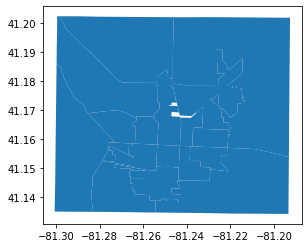

In [93]:
#portage[portage["prec_id"].isna()]

#portage[(~portage["prec_id"].isna())&(portage["prec_id"].str.upper().str.contains("SUGAR"))]

portage[(~portage["prec_id"].isna())&(portage["prec_id"].str.upper().str.contains("RAVENNA"))].plot()

In [94]:
portage[(~portage["prec_id"].isna())&(portage["prec_id"].str.upper().str.contains("RAVENNA"))]

,OBJECTID_1,OBJECTID,NAME,PRECINCT,number,Shape_STAr,Shape_STLe,geometry,prec_id,county,UNIQUE_ID
71,72,882,Ravenna Township,D,(107),7.884461e+07,45951.670924,"POLYGON ((-81.27881 41.15253, -81.27881 41.152...",PRECINCT RAVENNA TWP D,PORTAGE,PORTAGE-PRECINCT RAVENNA TWP D
72,73,889,Ravenna Township,C,(106),1.660928e+07,17794.321230,"POLYGON ((-81.26311 41.16734, -81.26312 41.167...",PRECINCT RAVENNA TWP C,PORTAGE,PORTAGE-PRECINCT RAVENNA TWP C
85,86,909,Ravenna,1B,(002),9.695859e+06,12723.099105,"POLYGON ((-81.25335 41.16055, -81.25353 41.158...",PRECINCT RAVENNA 1-B,PORTAGE,PORTAGE-PRECINCT RAVENNA 1-B
86,87,911,Ravenna,3A,(006),7.815697e+06,11211.248646,"POLYGON ((-81.24315 41.15768, -81.24325 41.156...",PRECINCT RAVENNA 3-A,PORTAGE,PORTAGE-PRECINCT RAVENNA 3-A
87,88,913,Ravenna,4B,(010),1.067889e+07,16620.513804,"POLYGON ((-81.23852 41.15497, -81.23837 41.157...",PRECINCT RAVENNA 4-B,PORTAGE,PORTAGE-PRECINCT RAVENNA 4-B
88,89,919,Ravenna,2B,(004),1.031201e+07,14120.528904,"POLYGON ((-81.23293 41.16393, -81.23296 41.163...",PRECINCT RAVENNA 2-B,PORTAGE,PORTAGE-PRECINCT RAVENNA 2-B
89,90,881,Ravenna,2C,(005),4.127759e+07,56983.214334,"POLYGON ((-81.24356 41.16922, -81.24356 41.169...",PRECINCT RAVENNA 2-C,PORTAGE,PORTAGE-PRECINCT RAVENNA 2-C
90,91,886,Ravenna Township,G,(110),1.783122e+08,95739.192209,"POLYGON ((-81.19275 41.19058, -81.19283 41.184...",PRECINCT RAVENNA TWP G,PORTAGE,PORTAGE-PRECINCT RAVENNA TWP G
91,92,884,Ravenna Township,F,(109),9.573219e+07,54901.588493,"POLYGON ((-81.22973 41.14560, -81.22954 41.145...",PRECINCT RAVENNA TWP F,PORTAGE,PORTAGE-PRECINCT RAVENNA TWP F
92,93,915,Ravenna,4A,(009),1.136283e+07,16572.102773,"POLYGON ((-81.23683 41.15240, -81.23674 41.152...",PRECINCT RAVENNA 4-A,PORTAGE,PORTAGE-PRECINCT RAVENNA 4-A


<AxesSubplot:>

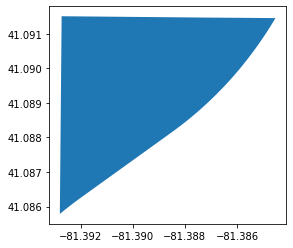

In [65]:
tallmadge_multi[tallmadge_multi["level_1"]==1].plot()

In [61]:
portage[(~portage["prec_id"].isna())&(portage["prec_id"].str.upper().str.contains("BRIMFIELD A"))]

,OBJECTID_1,OBJECTID,NAME,PRECINCT,number,Shape_STAr,Shape_STLe,geometry,prec_id,county,UNIQUE_ID
114,119,843,Brimfield Township,A,(062),9.839466e+07,89938.769136,"MULTIPOLYGON (((-81.37867 41.13481, -81.37867 ...",PRECINCT BRIMFIELD A,PORTAGE,PORTAGE-PRECINCT BRIMFIELD A


<AxesSubplot:>

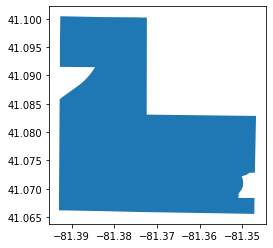

In [62]:
portage[(~portage["prec_id"].isna())&(portage["prec_id"].str.upper().str.contains("BRIMFIELD E"))].plot()

<AxesSubplot:>

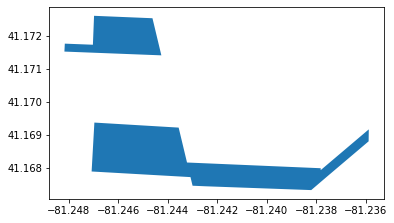

In [73]:
portage[(portage["NAME"]=="RavennaTownship")|(portage["NAME"]=="Ravenna Township")&(portage["prec_id"].isna())].plot()


In [96]:
portage["prec_id"][(~portage["prec_id"].isna())&(portage["prec_id"].str.upper().str.contains("RAVENNA"))].unique()

array(['PRECINCT RAVENNA TWP D', 'PRECINCT RAVENNA TWP C',
       'PRECINCT RAVENNA 1-B', 'PRECINCT RAVENNA 3-A',
       'PRECINCT RAVENNA 4-B', 'PRECINCT RAVENNA 2-B',
       'PRECINCT RAVENNA 2-C', 'PRECINCT RAVENNA TWP G',
       'PRECINCT RAVENNA TWP F', 'PRECINCT RAVENNA 4-A',
       'PRECINCT RAVENNA 2-A', 'PRECINCT RAVENNA TWP A',
       'PRECINCT RAVENNA TWP B', 'PRECINCT RAVENNA 1-A',
       'PRECINCT RAVENNA 3-B', 'PRECINCT RAVENNA 3-C',
       'PRECINCT RAVENNA TWP E'], dtype=object)

In [127]:
portage[(portage["NAME"]=="RavennaTownship")|(portage["NAME"]=="Ravenna Township")&(portage["prec_id"].isna())|
        (portage["prec_id"]=="PRECINCT RAVENNA 1-A")|(portage["prec_id"]=="PRECINCT RAVENNA 2-A")|(portage["prec_id"]=="PRECINCT RAVENNA 2-C")]#.plot()

,OBJECTID_1,OBJECTID,NAME,PRECINCT,number,Shape_STAr,Shape_STLe,geometry,prec_id,county,UNIQUE_ID
89,90,881,Ravenna,2C,(005),4.127759e+07,56983.214334,"POLYGON ((-81.24356 41.16922, -81.24356 41.169...",PRECINCT RAVENNA 2-C,PORTAGE,PORTAGE-PRECINCT RAVENNA 2-C
96,97,918,Ravenna,2A,(003),8.064399e+06,14824.419315,"POLYGON ((-81.23245 41.17120, -81.23293 41.163...",PRECINCT RAVENNA 2-A,PORTAGE,PORTAGE-PRECINCT RAVENNA 2-A
105,106,0,Ravenna Township,None,None,9.824993e+05,7578.988828,"POLYGON ((-81.24704 41.16835, -81.24696 41.169...",NaN,PORTAGE,NaN
106,107,0,RavennaTownship,None,None,3.161934e+05,2873.250034,"POLYGON ((-81.24698 41.17242, -81.24697 41.172...",NaN,PORTAGE,NaN
128,134,908,Ravenna,1A,(001),2.157679e+07,30334.257823,"POLYGON ((-81.24907 41.18405, -81.24907 41.183...",PRECINCT RAVENNA 1-A,PORTAGE,PORTAGE-PRECINCT RAVENNA 1-A


In [139]:
portage[portage["PRECINCT"]=="1C"]#.plot()

,OBJECTID_1,OBJECTID,NAME,PRECINCT,number,Shape_STAr,Shape_STLe,geometry,prec_id,county,UNIQUE_ID
44,45,837,Streetsboro,1C,(048),2.277243e+07,21867.249995,"POLYGON ((-81.34539 41.25310, -81.34548 41.246...",PRECINCT STREETSBORO 1-C,PORTAGE,PORTAGE-PRECINCT STREETSBORO 1-C
68,69,878,Kent,1C,(013),7.732311e+06,13381.904064,"POLYGON ((-81.36418 41.16886, -81.36418 41.168...",PRECINCT KENT 1-C,PORTAGE,PORTAGE-PRECINCT KENT 1-C


<AxesSubplot:>

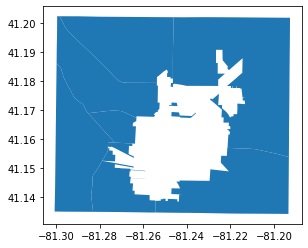

In [92]:
portage[(portage["NAME"]=="RavennaTownship")|(portage["NAME"]=="Ravenna Township")].plot()

<AxesSubplot:>

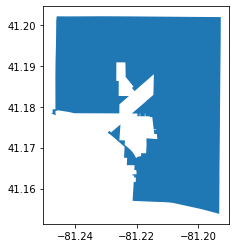

In [76]:
portage[portage["prec_id"]=="PRECINCT RAVENNA TWP G"].plot()

129 (137, 11) 129


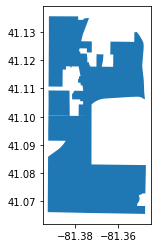

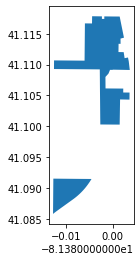

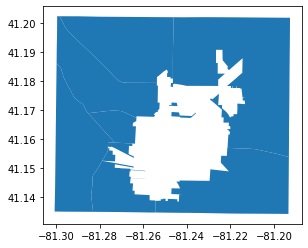

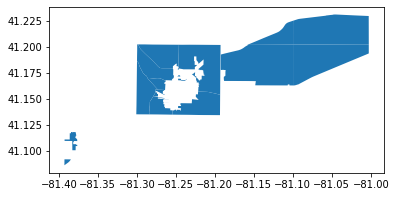

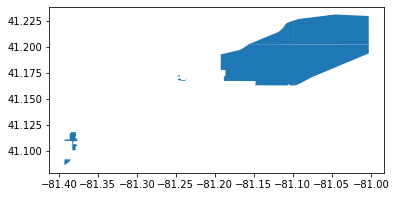

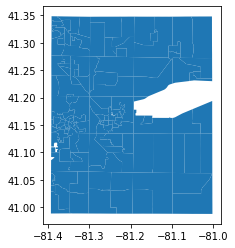

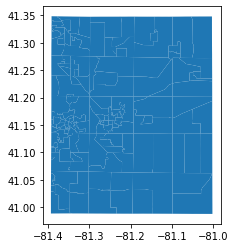

In [38]:
portage[(~portage["prec_id"].isna())&(portage["prec_id"].str.upper().str.contains("BRIMFIELD A"))|(portage["prec_id"].str.upper().str.contains("BRIMFIELD E"))].plot()

portage[portage["NAME"]=="Tallmadge"].plot()

portage[(portage["NAME"]=="RavennaTownship")|(portage["NAME"]=="Ravenna Township")].plot()

portage[(portage["NAME"]=="RavennaTownship")|(portage["NAME"]=="Ravenna Township")|(portage["PRECINCT"]=="Arsenal")|(portage["NAME"]=="Tallmadge")].plot()

portage[portage["prec_id"].isna()].plot()#+portage["PRECINCT"][portage["prec_id"].isna()])

portage[~portage["prec_id"].isna()].plot()

portage.plot()


print(portage["prec_id"][~portage["prec_id"].isna()].nunique(), 
     portage.shape,
     er22["PRECNAME"][er22["County"].str.upper()=="PORTAGE"].nunique())

## WIP Merge

Plan to dissolve by UNIQUE_ID before joining after concatenating boundaries to account for cases such that there are multiple geometries for a given precinct

If this will cause issues, perhaps should be done before concat all?

In [43]:
bound20_reused_counties_gdf[bound20_reused_counties_gdf["COUNTYNM"].str.upper()=="LORAIN"]#.nunique()

,UNIQUE_ID,STATEFP20,COUNTYFP20,PRECINCT20,NAME20,geometry,COUNTY,COUNTYNM,UNIQUE_ID_code
705,093-AKK,39,093,AKK,SHEFFIELD TWP WEST,"POLYGON ((-82.15846 41.42168, -82.15844 41.421...",Lorain County,lorain,LORAIN-AKK
706,093-AKH,39,093,AKH,SHEFFIELD TWP EAST,"POLYGON ((-82.13064 41.42424, -82.12949 41.424...",Lorain County,lorain,LORAIN-AKH
707,093-ACG,39,093,ACG,ELYRIA CITY 3-D,"POLYGON ((-82.08861 41.35422, -82.08825 41.354...",Lorain County,lorain,LORAIN-ACG
708,093-ACD,39,093,ACD,ELYRIA CITY 3-A,"POLYGON ((-82.07831 41.35180, -82.07717 41.351...",Lorain County,lorain,LORAIN-ACD
709,093-ACP,39,093,ACP,ELYRIA CITY 4-D,"POLYGON ((-82.11374 41.41819, -82.10792 41.418...",Lorain County,lorain,LORAIN-ACP
...,...,...,...,...,...,...,...,...,...
8664,093-ALJ,39,093,ALJ,N. RIDGEVILLE 3-F,"POLYGON ((-82.04770 41.35958, -82.04630 41.359...",Lorain County,lorain,LORAIN-ALJ
8665,093-ABO,39,093,ABO,AVON LAKE CITY 4-D,"POLYGON ((-82.04741 41.47878, -82.04719 41.479...",Lorain County,lorain,LORAIN-ABO
8666,093-ALK,39,093,ALK,N. RIDGEVILLE 3-G,"POLYGON ((-81.99744 41.36830, -81.99146 41.373...",Lorain County,lorain,LORAIN-ALK
8700,093-AJT,39,093,AJT,GRAFTON VILL #3/#4,"POLYGON ((-82.08006 41.28604, -82.07936 41.286...",Lorain County,lorain,LORAIN-AJT


In [22]:
er22[er22["County"].str.upper() == "MARION"].shape

(45, 259)

In [18]:
bound20_reused_counties_gdf["UNIQUE_ID_og"] = bound20_reused_counties_gdf["UNIQUE_ID"].copy()
bound20_reused_counties_gdf["UNIQUE_ID"] = bound20_reused_counties_gdf["UNIQUE_ID_code"]
bound20_reused_counties_gdf["county"] = bound20_reused_counties_gdf["COUNTYNM"].str.upper()

'''#Is Lucas issue related to monclave and sylvania?
#Yes, so, does LUCAS-AWB go with LUCAS-ZZZ? 
#In metadata, "Monclova 2,5,7,10 are mismatched.  And Sylvania Township A has two pieces in shapefile, but one row in SoS election results.  See readme."
#What does this mean for what to do here?
For now I will match LUCAS-AWB go with LUCAS-ZZZ and can change later
No - because AWB is not zero vote prec. So, instead should ZZZ be AWB?
#er22.loc[er22["UNIQUE_ID"]=="LUCAS-AWB", "UNIQUE_ID"] = "LUCAS-ZZZ"
'''
print("check email exchange for Lucas county to confirm if this is reasonable")
bound20_reused_counties_gdf.loc[bound20_reused_counties_gdf["UNIQUE_ID"]== "LUCAS-ZZZ","UNIQUE_ID"] = "LUCAS-AWB"


#Note to_checkout to be removed
wip_full_match_list = full_match_22_bound + too_many_polygons + [bound20_reused_counties_gdf] + to_checkout
wip_full_match_gdf = gp.GeoDataFrame(pd.concat(wip_full_match_list, ignore_index=True), crs=bound20_reused_counties_gdf.crs)
wip_full_match_gdf = wip_full_match_gdf[["UNIQUE_ID", "prec_id", "county", "COUNTYFP20", "COUNTYNM", "geometry"]]


er22.loc[er22["County"].str.lower().isin(counties_reused22_set), "UNIQUE_ID"] = er22["County"].str.upper() + "-"+er22["PRECCODE"]
er22["UNIQUE_ID"] = er22["UNIQUE_ID"].str.upper()
er22["county"] = er22["County"].str.upper()


wip_pber_merge = pd.merge(er22, wip_full_match_gdf, on = ["UNIQUE_ID", "county"], how = "outer", indicator=True)


print("wip_full_match_gdf unique_id count: ",wip_full_match_gdf["UNIQUE_ID"].nunique(),"\nwip_full_match_gdf unique_id null count: ",len(wip_full_match_gdf["UNIQUE_ID"][wip_full_match_gdf["UNIQUE_ID"].isna()]))
print("wip_full_match_gdf shape: ",wip_full_match_gdf.shape)
print("er22 shape: ",er22.shape)
print("merge shape: ",wip_pber_merge.shape)

BECAUSE IMPORTANT TO OHIO, SHOULD MAP/ADD STATE CODE -- OR THIS CAN COME FROM ER??
wip_full_match_gdf unique_id count:  8724 
wip_full_match_gdf unique_id null count:  0
wip_full_match_gdf shape:  (8905, 6)
er22 shape:  (8933, 260)
merge shape:  (9144, 265)


/Users/lilyfalk/anaconda3/envs/hdv_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Export WIP

In [15]:
wip_full_match_gdf.to_file("./wip_updated_precs/wip_full_match.shp")
bound20_reused_counties_gdf.to_file("./wip_updated_precs/bound20_reused.shp")

<ipython-input-15-8bf4796f332a>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bound20_reused_counties_gdf.to_file("./wip_updated_precs/bound20_reused.shp")


### Look into non-unique UNIQUE_ID

In [14]:
wip_pber_merge[wip_pber_merge["_merge"]!="both"]

,UNIQUE_ID,COUNTYFP,County,PRECNAME,PRECCODE,Region,Market,REGVOT,BALLOTS,TURNOUT,...,GSU31RLAN,GSU33DHAG,GSU33RRUL,county_x,prec_id,county_y,COUNTYFP20,COUNTYNM,geometry,_merge
5515,LORAIN-ALN,93.0,Lorain,PRECINCT AVON LAKE CITY 1-E,ALN,Northeast,Cleveland,815.0,536.0,0.657669,...,0.0,0.0,0.0,LORAIN,NaN,NaN,NaN,NaN,None,left_only
5516,LORAIN-ALO,93.0,Lorain,PRECINCT AVON LAKE CITY 2-E,ALO,Northeast,Cleveland,953.0,640.0,0.671563,...,0.0,0.0,0.0,LORAIN,NaN,NaN,NaN,NaN,None,left_only
5517,LORAIN-ALP,93.0,Lorain,PRECINCT AVON CITY 1-F,ALP,Northeast,Cleveland,530.0,342.0,0.645283,...,0.0,0.0,0.0,LORAIN,NaN,NaN,NaN,NaN,None,left_only
5518,LORAIN-ALQ,93.0,Lorain,PRECINCT AVON CITY 1-G,ALQ,Northeast,Cleveland,844.0,528.0,0.625592,...,0.0,0.0,0.0,LORAIN,NaN,NaN,NaN,NaN,None,left_only
5519,LORAIN-ALR,93.0,Lorain,PRECINCT LORAIN CITY 8-G,ALR,Northeast,Cleveland,1037.0,658.0,0.634523,...,0.0,0.0,0.0,LORAIN,NaN,NaN,NaN,NaN,None,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9139,MARION-AAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,MARION,101,marion,"POLYGON ((-83.12288 40.60533, -83.12158 40.605...",right_only
9140,MARION-AAQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,MARION,101,marion,"POLYGON ((-83.15386 40.57642, -83.15385 40.576...",right_only
9141,PORTAGE-ZZZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,PORTAGE,133,portage,"POLYGON ((-81.19275 41.19287, -81.19252 41.192...",right_only
9142,ASHTABULA-ZZZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,ASHTABULA,007,ashtabula,"POLYGON ((-81.00983 42.25160, -81.00557 42.252...",right_only


In [24]:
wip_pber_merge["county"][wip_pber_merge["_merge"]!="both"].unique()

array(['LORAIN', 'LUCAS', 'MARION', 'PORTAGE', 'WOOD', 'OTTAWA', 'ERIE',
       'LAKE', 'CUYAHOGA', 'ASHTABULA'], dtype=object)

In [27]:
wip_pber_merge["county"][(wip_pber_merge["_merge"]!="both")&(~wip_pber_merge["UNIQUE_ID"].str.contains("ZZZ"))].unique()

array(['LORAIN', 'LUCAS', 'MARION', 'PORTAGE', 'WOOD'], dtype=object)

In [43]:
#Portage and Wood known WIP
#Lucas addressed above - temporary fix - should this be modified?
#Look further into: Lorain, , Marion
#[wip_pber_merge.columns[wip_pber_merge.columns.str.startswith("G")]]
#wip_pber_merge[(wip_pber_merge["_merge"]!="both")&(wip_pber_merge["county"]=="LORAIN")]

wip_pber_merge[(wip_pber_merge["_merge"]!="both")&(wip_pber_merge["county"]=="MARION")]

,UNIQUE_ID,COUNTYFP,County,PRECNAME,PRECCODE,Region,Market,REGVOT,BALLOTS,TURNOUT,...,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,county,prec_id,COUNTYFP20,COUNTYNM,geometry,_merge
6075,MARION-AAB,101.0,Marion,PRECINCT MARION 1-B,AAB,Central,Columbus,1104.0,452.0,0.409420,...,0.0,0.0,0.0,0.0,MARION,NaN,NaN,NaN,None,left_only
6086,MARION-ABC,101.0,Marion,PRECINCT MARION 5-B,ABC,Central,Columbus,943.0,375.0,0.397667,...,0.0,0.0,0.0,0.0,MARION,NaN,NaN,NaN,None,left_only
9120,MARION-ABU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MARION,NaN,101,marion,"POLYGON ((-83.30569 40.57123, -83.30568 40.572...",right_only
9121,MARION-ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MARION,NaN,101,marion,"POLYGON ((-82.97391 40.63946, -82.97391 40.640...",right_only
9122,MARION-ACD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MARION,NaN,101,marion,"POLYGON ((-83.10998 40.66512, -83.10967 40.665...",right_only
9123,MARION-ACC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MARION,NaN,101,marion,"POLYGON ((-83.15361 40.68805, -83.15354 40.688...",right_only
9124,MARION-ACE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MARION,NaN,101,marion,"POLYGON ((-83.21554 40.53435, -83.21546 40.534...",right_only
9125,MARION-AAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MARION,NaN,101,marion,"POLYGON ((-83.12900 40.62937, -83.12842 40.630...",right_only
9126,MARION-ACL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MARION,NaN,101,marion,"MULTIPOLYGON (((-83.09330 40.56971, -83.09325 ...",right_only
9127,MARION-ABI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MARION,NaN,101,marion,"POLYGON ((-83.12601 40.59063, -83.12496 40.590...",right_only


In [52]:
gg = wip_pber_merge[~wip_pber_merge["county"].isin(['LORAIN', 'LUCAS', 'MARION', 'PORTAGE', 'WOOD', "CLERMONT","BROWN","STARK"])]
print(gg.shape)
print(gg["UNIQUE_ID"].nunique())

(7677, 265)
7677


In [51]:
[gg["UNIQUE_ID"].value_counts()[gg["UNIQUE_ID"].value_counts()>1]]

[BROWN-GEORGETOWN EAST    4
 BROWN-PLEASANT TWP       3
 BROWN-JACKSON TWP        2
 BROWN-FRANKLIN TWP       2
 BROWN-EAGLE TWP          2
 BROWN-MT ORAB SOUTH      2
 STARK-CANTON CITY 6-A    2
 BROWN-PIKE TWP EAST      2
 Name: UNIQUE_ID, dtype: int64]

In [33]:
wip_pber_merge[wip_pber_merge.columns[wip_pber_merge.columns.str.startswith("G")]][wip_pber_merge["UNIQUE_ID"]=='LUCAS-AWB']

,G22ATGDCRO,G22ATGRYOS,G22AUDDSAP,G22AUDRFAB,G22CJUDBRU,G22CJURKEN,G22GOVDSTE,G22GOVRDEW,G22JUSDJAM,G22JUSDZAY,...,GSU23DANT,GSU23RSIM,GSU25DDEM,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL
5837,230.0,497.0,235.0,477.0,255.0,459.0,200.0,526.0,242.0,248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
[wip_full_match_gdf["UNIQUE_ID"].value_counts()[wip_full_match_gdf["UNIQUE_ID"].value_counts()>1]]

[CLERMONT-WILLIAMSBURG VILLAGE C    11
 CLERMONT-BATAVIA VILLAGE A         10
 CLERMONT-WAYNE TOWNSHIP C          10
 CLERMONT-PIERCE TOWNSHIP N          8
 CLERMONT-BATAVIA TOWNSHIP O         6
                                    ..
 BROWN-FRANKLIN TWP                  2
 CLERMONT-GOSHEN TOWNSHIP A          2
 CLERMONT-STONELICK TOWNSHIP D       2
 CLERMONT-MIAMI TOWNSHIP T           2
 CLERMONT-WAYNE TOWNSHIP A           2
 Name: UNIQUE_ID, Length: 85, dtype: int64]

In [95]:
#wip_full_match_gdf[wip_full_match_gdf["UNIQUE_ID"].isna()]
wip_full_match_gdf[(wip_full_match_gdf["UNIQUE_ID"].isin(wip_full_match_gdf["UNIQUE_ID"][wip_full_match_gdf["UNIQUE_ID"].value_counts()[wip_full_match_gdf["UNIQUE_ID"].value_counts()>1]]))]

,FeatId1,PRECINCTNO,NAME,geometry,prec_id,county,UNIQUE_ID,OBJECTID,PRECINCT,SPLITS,...,TWP_NUM,PREC_NUM,NEW_CODE,RECNO,STATEFP20,COUNTYFP20,PRECINCT20,NAME20,COUNTYNM,UNIQUE_ID_code
0,0.0,0280,PLEASANT TWP,"POLYGON Z ((-83.89765 38.85235 0.00000, -83.89...",PLEASANT TWP,BROWN,BROWN-PLEASANT TWP,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0230,GEORGETOWN EAST,"POLYGON Z ((-83.89764 38.85263 0.00000, -83.89...",GEORGETOWN EAST,BROWN,BROWN-GEORGETOWN EAST,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0080,MT ORAB SOUTH,"POLYGON Z ((-83.87706 39.01579 0.00000, -83.87...",MT ORAB SOUTH,BROWN,BROWN-MT ORAB SOUTH,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0350,WASHINGTON TWP,"POLYGON Z ((-83.79618 39.00186 0.00000, -83.79...",WASHINGTON TWP,BROWN,BROWN-WASHINGTON TWP,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0270,GEORGETOWN SW,"POLYGON Z ((-83.90350 38.86024 0.00000, -83.90...",GEORGETOWN SW,BROWN,BROWN-GEORGETOWN SW,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,0240,GEORGETOWN NORTH,"POLYGON Z ((-83.89334 38.88747 0.00000, -83.88...",GEORGETOWN NORTH,BROWN,BROWN-GEORGETOWN NORTH,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,0230,GEORGETOWN EAST,"POLYGON Z ((-83.89048 38.84390 0.00000, -83.89...",GEORGETOWN EAST,BROWN,BROWN-GEORGETOWN EAST,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,0230,GEORGETOWN EAST,"POLYGON Z ((-83.89013 38.84814 0.00000, -83.89...",GEORGETOWN EAST,BROWN,BROWN-GEORGETOWN EAST,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,0230,GEORGETOWN EAST,"POLYGON Z ((-83.88592 38.86084 0.00000, -83.88...",GEORGETOWN EAST,BROWN,BROWN-GEORGETOWN EAST,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,0280,PLEASANT TWP,"POLYGON Z ((-83.88416 38.89999 0.00000, -83.88...",PLEASANT TWP,BROWN,BROWN-PLEASANT TWP,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
wip_pber_merge["County"][wip_pber_merge["_merge"]!="both"].unique()
#clark, lorain, lucas, marion not expected, except they are expected from earlier join...

array(['Butler', 'Clark', 'Cuyahoga', 'Erie', 'Lorain', 'Lucas', 'Marion',
       'Pickaway', 'Portage', 'Stark', 'Wood', nan], dtype=object)

In [138]:
wip_pber_merge["county"][wip_pber_merge["_merge"]!="both"].unique()

array([nan], dtype=object)

In [139]:
wip_pber_merge["county"].unique()

array([nan, 'BROWN', 'CLERMONT', 'COLUMBIANA', 'DELAWARE', 'GEAUGA',
       'HAMILTON', 'HARDIN', 'HOCKING', 'LAKE', 'MEDINA', 'MERCER',
       'MIAMI', 'MONTGOMERY', 'MUSKINGUM', 'TUSCARAWAS'], dtype=object)

In [140]:
wip_pber_merge["County"].unique()

array(['Adams', 'Allen', 'Ashland', 'Ashtabula', 'Athens', 'Auglaize',
       'Belmont', 'Brown', 'Butler', 'Carroll', 'Champaign', 'Clark',
       'Clermont', 'Clinton', 'Columbiana', 'Coshocton', 'Crawford',
       'Cuyahoga', 'Darke', 'Defiance', 'Delaware', 'Erie', 'Fairfield',
       'Fayette', 'Franklin', 'Fulton', 'Gallia', 'Geauga', 'Greene',
       'Guernsey', 'Hamilton', 'Hancock', 'Hardin', 'Harrison', 'Henry',
       'Highland', 'Hocking', 'Holmes', 'Huron', 'Jackson', 'Jefferson',
       'Knox', 'Lake', 'Lawrence', 'Licking', 'Logan', 'Lorain', 'Lucas',
       'Madison', 'Mahoning', 'Marion', 'Medina', 'Meigs', 'Mercer',
       'Miami', 'Monroe', 'Montgomery', 'Morgan', 'Morrow', 'Muskingum',
       'Noble', 'Ottawa', 'Paulding', 'Perry', 'Pickaway', 'Pike',
       'Portage', 'Preble', 'Putnam', 'Richland', 'Ross', 'Sandusky',
       'Scioto', 'Seneca', 'Shelby', 'Stark', 'Summit', 'Trumbull',
       'Tuscarawas', 'Union', 'Van Wert', 'Vinton', 'Warren',
       'Washington

In [136]:
wip_pber_merge["UNIQUE_ID"][wip_pber_merge["_merge"]!="both"].str.split("-")[0].unique()#[1]#[1]

KeyError: 0

## No longer relevant: 

In [347]:
#wip_updated_precs_list = [brown,butler,clark,clermont,columbiana, cuyahoga,delaware,erie,geauga,hamilton,hardin,hocking,lake,mercer, miami, stark]
#wip_updated_precs_list = list(prec_counties_new22_set)
#why is tuscarawas missing in QGIS?
wip_updated_precs_list = [cuyahoga,portage,erie,miami,lake,hamilton, wood, hocking,tuscarawas,pickaway,clermont,montgomery,stark,
                          geauga,muskingum,columbiana,clark,delaware,medina,butler,brown,mercer,hardin]
wip_updated_precs_gdf = gp.GeoDataFrame(pd.concat(wip_updated_precs_list, ignore_index=True), crs=bound20_reused_counties_gdf.crs)

#assert wip_updated_precs_gdf["UNIQUE_ID"].isna().any()==False
#wip_updated_precs_gdf.dissolve(by="prec_id").reset_index()
#print("wip shape: ", wip_updated_precs_gdf.shape)
#print("wip unique id count: ", wip_updated_precs_gdf["UNIQUE_ID"].nunique())

#Export shp
#wip_updated_precs_gdf.to_file("./wip_updated_precs/wip_updated_precs.shp")
#bound20_reused_counties_gdf.to_file("./wip_updated_precs/bound20_reused.shp")

### 2020 map fine to use, but have boundaries collected in 2022 as well

In [ ]:
fulton = gp.read_file("./boundaries/fulton_precincts_2022/Fulton County Ohio Voting Precincts.shp")

henry = gp.read_file("./boundaries/henry_precincts_2022/CountyVotingPrecincts.shp")

knox = gp.read_file("./boundaries/knox_precincts_2022/vote_precincts.shp")

licking = gp.read_file("./boundaries/licking_precincts_2022/LickingCounty_Precincts_20230216.shp")

logan = gp.read_file("./boundaries/logan_precincts_2022/logan county precincts 2018.shp")

lucas = gp.read_file("./boundaries/lucas_precincts_2022/BOE.shp")

marion = gp.read_file("./boundaries/marion_precincts_2022/City_Council_Wards_December2022.shp")

morrow = gp.read_file("./boundaries/morrow_precincts_2022/MorrowVoting.shp") #WIP

noble = "No geospatial data obtained"

ottawa = gp.read_file("./boundaries/ottawa_precincts_2022/VotingPrecincts.shp")

paulding = gp.read_file("./boundaries/paulding_precincts_2022/Election_Precincts.shp")

perry = gp.read_file("./boundaries/perry_precincts_2022/PerryCountyVotingPrecincts.shp")

pike = "No geospatial data obtained."

preble = "Outdated geospatial file obtained. Up to date pdf obtained."

putnam = gp.read_file("./boundaries/putnam_precincts_2022/Putnam Voter Precincts.shp")

richland = gp.read_file("./boundaries/richland_precincts_2022/Precincts_RichlandCounty.shp")

ross = "No geospatial data in drive, wip, pdf available"

sandusky = "No geospatial data obtained"

scioto = "No geospatial data obtained"

shelby = gp.read_file("./boundaries/shelby_precincts_2022/Shelby_County_Precincts.shp")

summit = gp.read_file("./boundaries/summit_precincts_2022/Precinct_region.shp")

union = gp.read_file("./boundaries/union_precincts_2022/precinct_region.shp")

vanwert = "No geospatial data obtained"

warren = gp.read_file("./boundaries/warren_precincts_2022/WarrenCountyVotingPrecincts_nov2022.shp")

wayne = gp.read_file("./boundaries/wayne_precincts_2023/Wayne_County_Voting_Precinct_preliminary.shp") #not necessarily accurate to any election use

williams = gp.read_file("./boundaries/williams_precincts_2022/Voting_Precincts.shp")

### County dict to be added to for full summary:

In [128]:
county_dict = {"ashtabula":ashtabula,
               "adams":adams, 
               "allen":allen,
               "auglaize":auglaize,
               "brown":brown,
               "butler": butler,
               "carroll": carroll,
               "champaign": champaign,
               "clinton": clinton,
               "clark": clark,
               "clermont": clermont,
               "coshocton": coshocton,
               "crawford": crawford,
               "cuyahoga": cuyahoga,
               "darke": darke,
               "defiance": defiance,
               "delaware": delaware,
               "erie": erie,
               "fairfield": fairfield,
               "fayette": fayette,
               "franklin": franklin,
               "fulton": fulton,
               "gallia": gallia,
               "greene": greene,
               "guernsey": guernsey,
               "hamilton": hamilton,
               "hardin": hardin,
               "hancock_findlay": hancock_findlay,
               "henry": henry,
               "highland": highland,
               "hocking": hocking,
               "holmes": holmes,
               "huron": huron,
               "jackson": jackson,
               "knox": knox,
               "lake": lake,
               "licking": licking,
               "logan": logan,
               "lucas": lucas,
               "madison": madison,
               "marion": marion,
               "meigs": meigs,
               "mercer": mercer,
               "miami": miami,
               "montgomery": montgomery,
               "morrow": morrow,
               "noble": noble,
               "ottawa": ottawa,
               "paulding": paulding,
               "perry": perry,
               "pickaway": pickaway,
               "pike": pike,
               "preble": preble,
               "putnam": putnam,
               "richland": richland,
               "ross": ross,
               "sandusky": sandusky,
               "scioto": scioto,
               "shelby": shelby,
               "summit": summit,
               "tuscarawas": tuscarawas,
               "union": union,
               "vanwert": vanwert,
               "warren": warren,
               "wayne": wayne,
               "williams": williams,
               "wood": wood,
               "wyandot": wyandot
              }

NameError: name 'adams' is not defined

In [ ]:
#Ashtabula: Full match - reuse 2020, particularly as it contains a ZZZ precinct
#ashtabula = gp.read_file("./boundaries/ashtabula_precincts_2023/Voting_Precincts_2023_AG.shp")
#ashtabula['prec_id']="PRECINCT "+ashtabula['Precinct1'].str.upper()
#ashtabula['county'] = "ASHTABULA"
#ashtabula['UNIQUE_ID'] = ashtabula['county'] + "-" + ashtabula['prec_id']

#Allen - no shapefile obtained - need to digitize? --> Use 2020


#Fayette: Full match - can use 2020
#fayette = gp.read_file("./boundaries/fayette_precincts_2022/Elections_Precincts_City_County.shp")
#fayette['prec_id'] = fayette["PRECINCT"]
#fayette["county"] = "FAYETTE"
#fayette_prec_dict = {'1B':'WASHINGTON 1B','1C':'WASHINGTON 1C','2A':'WASHINGTON 2A','2D':'WASHINGTON 2D','3A':'WASHINGTON 3A','3D':'WASHINGTON 3D','3F':'WASHINGTON 3F','4A':'WASHINGTON 4A','4B':'WASHINGTON 4B','4C':'WASHINGTON 4C','4D':'WASHINGTON 4D',
#                     'CONCORD / GREEN':'CONCORD/GREEN','UNION SOUTH / WEST':'UNION SOUTH/WEST'}
#fayette.loc[fayette['PRECINCT'].isin(fayette_prec_dict.keys()), "prec_id"] = fayette["PRECINCT"].map(fayette_prec_dict)
#fayette["UNIQUE_ID"] = fayette["county"] + "-" + fayette["prec_id"]
